High level overview of steps:



*   First you need to get your connection from this notebook to Milvus and set up a cluster.
*   Then we'll need to programmatically import our images from Google Drive.
*   Set up our Zilliz Cloud
*   Insert the data
*   Then do our search with ResNet 50 and repeat with Resnet 152


Here is a link to the zip file of the photos I'm using: https://drive.google.com/file/d/1mqAJp5HiTB6zQFgm5DA92jGQcx_zUxMi/view?usp=sharing







In [1]:
!pip3 install pymilvus==2.2.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.57.0
    Uninstalling grpcio-1.57.0:
      Successfully uninstalled grpcio-1.57.0


It didn't say to force a specific version of grpcio in the docs, but I needed to do this for it to work.

In [2]:
!pip3 install --no-cache-dir  --force-reinstall -Iv grpcio==1.49.1

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 7.2 MB/s eta 0:00:00


In [2]:
cd /content/content/cloud-vectordb-examples

/content/content/cloud-vectordb-examples


In [3]:
cd /content/content/cloud-vectordb-examples/python

/content/content/cloud-vectordb-examples/python


We are going to use pymilvus to connect to Zilliz Cloud, torch to run the embedding model, torchvision for the actual model and preprocessing, gdown to access our dataset and tqdm for loading bars.

In [4]:
!pip install pymilvus torch gdown torchvision tqdm

We are going to use gdown to grab the zip from Google Drive and then decompress it with the built-in zipfile library. (docs)

In [5]:
import gdown
import zipfile

Downloading the images.

We're using the following docs for image search: https://docs.zilliz.com/docs/image-search-with-zilliz-cloud-and-pytorch

Fuzzy=True is different from the docs, but the gdown docs had it and I needed it to make the code run. I couldn't figure out how to create the type of link that's in the Zilliz docs. Check if the files are there, if there don't run it :)


In [6]:
# Define the Google Drive link to the file you want to download
url = 'https://drive.google.com/file/d/1mqAJp5HiTB6zQFgm5DA92jGQcx_zUxMi/view?usp=sharing'

# Set the output path and filename for the downloaded file
output = './familypics.zip'

# Download the file from the given Google Drive link using gdown
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

# Use the zipfile module to extract the contents of "familypics.zip" into the "familypics" folder
with zipfile.ZipFile("./familypics.zip","r") as zip_ref:
    zip_ref.extractall("./familypics")

Downloading...
From: https://drive.google.com/uc?id=1mqAJp5HiTB6zQFgm5DA92jGQcx_zUxMi
To: /content/content/cloud-vectordb-examples/python/familypics.zip
100%|██████████| 1.42G/1.42G [00:16<00:00, 86.2MB/s]


Here we're just setting our parameters, the docs say "user" and "password", but you'll actually use your API key. (this is a common thing in docs)

In [7]:
# Zilliz Cloud Setup Arguments
COLLECTION_NAME = 'demo'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example
URI = 'https://in03-7658826fb79eac2.api.gcp-us-west1.zillizcloud.com'  # Endpoint URI obtained from Zilliz Cloud
API_KEY = '7473fc0c0030b2c69ee91d8f23dda664b8695eae1e63ba8ab4bd337fd624d55862655019dbd4dde62a92ebe43e63524c38c98a9f'

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3

Now we need to set up the cloud. To do this, first you'll connect to the Zilliz Cloud cluster using the provided URI.

In [8]:
from pymilvus import connections

# Connect to the cluster
connections.connect(uri=URI, token=API_KEY, secure=True)

If the collection already exists, drop it.

In [9]:
from pymilvus import utility

# Remove any previous collections with the same name
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

The collection will hold the ID, the file path of the image, and its embedding.

In [10]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

# Create collection which includes the id, filepath of the image, and image embedding
fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),  # VARCHARS need a maximum length, so for this example they are set to 200 characters
    FieldSchema(name='image_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]

schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

Create an index on the newly created collection and load it into memory.

In [11]:
# Create an AutoIndex index for collection
index_params = {
    'index_type': 'AUTOINDEX',
    'metric_type': 'L2',
    'params': {}
}
collection.create_index(field_name="image_embedding", index_params=index_params)
collection.load()

Get the filepaths of the images

In [12]:
import glob

# Get the filepaths of the images
paths = glob.glob('./familypics/*.jpg', recursive=True)
len(paths)

1619

Preprocess the data into batches. (creates a base model)

In [13]:
import torch


# Load a pre-trained ResNet-50 model.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# In PyTorch, a neural network model is a series of layers organized in a sequence.
# The resulting model will output the feature embeddings (activations)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.4MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Create the preprocessor for making sure all images are the same size before creating embeddings.

In [14]:
from torchvision import transforms

# Create preprocessor for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Insert the data.

In [15]:
from PIL import Image
from tqdm import tqdm

# Embed function that embeds the batch and inserts it
def embed(data): # [['img1', 'img2'], ['img1.jpg', 'img2.jpg']]
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()

        filenames_with_embedding = zip(data[1], output.tolist())

        inserts = []
        for filename_with_embedding in filenames_with_embedding:
            inserts.append({
              "image_embedding": filename_with_embedding[1],
              "filepath": filename_with_embedding[0],
           })

        collection.insert(inserts)

data_batch = [[],[]]

# Read the images into batches for embedding and insertion
# tdqm just gives the little loading bar
for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[],[]]

# Embed and insert the remainder
if len(data_batch[0]) != 0:
    embed(data_batch)

# Call a flush to index any unsealed segments.
# (means that the system or application needs to explicitly trigger the process of flushing
# any data that is currently stored in unsealed segments (such as a write-ahead log) to the final
# storage or index. This is essential because unflushed data is considered temporary and not yet fully durable.)
collection.flush()

100%|██████████| 1619/1619 [09:46<00:00,  2.76it/s]


Perform search!
We're just going to write a static list of 4 images.

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/loca

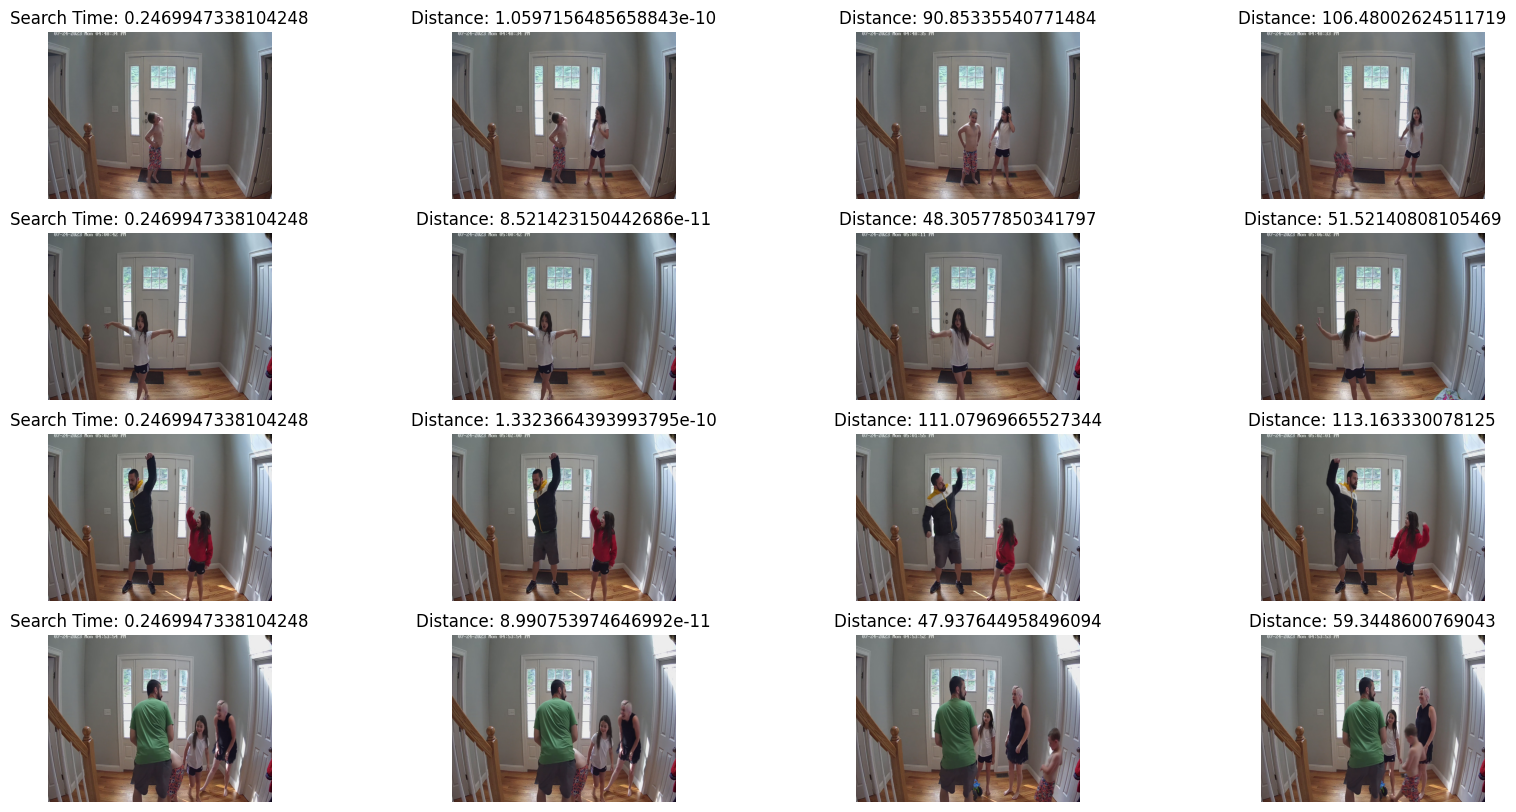

In [17]:
# Get the filepaths of the search images. We're picking specific images here because we'll be comparing 2 algorithms.
search_paths = [
    '/content/content/cloud-vectordb-examples/python/familypics/07-24-2023_16-48-37-295186.jpg',
    '/content/content/cloud-vectordb-examples/python/familypics/07-24-2023_17-00-45-218015.jpg',
    '/content/content/cloud-vectordb-examples/python/familypics/07-24-2023_17-02-03-215478.jpg',
    '/content/content/cloud-vectordb-examples/python/familypics/07-24-2023_16-53-57-272288.jpg',
]

#determining the number of search images
len(search_paths)

import time
from matplotlib import pyplot as plt

# Embed the search images
def embed(data):
    with torch.no_grad():
       # Pass the data through the model to obtain embeddings (vector representations).
        ret = model(torch.stack(data))
        ret = model(torch.stack(data))
        # If more than one image, use squeeze to remove the batch dimension
        if len(ret) > 1:
            return ret.squeeze().tolist()
        # Squeeze would remove batch for single image, so using flatten
        else:
            return torch.flatten(ret, start_dim=1).tolist()

# Initialize an empty data_batch list, which will be used to store image data and their corresponding file paths.
data_batch = [[],[]]

# Iterate through the search_paths to load the images and preprocess them.
for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

# Obtain embeddings for the search images by passing them through the model.
embeds = embed(data_batch[0])

# Record the start time before executing the search.
start = time.time()

# Perform a search using the embeddings obtained earlier. TOP_K specifies the number of top results to retrieve.
res = collection.search(embeds, anns_field='image_embedding', param={}, limit=TOP_K, output_fields=['filepath'])

# Record the finish time after executing the search.
finish = time.time()

# Show the image results using matplotlib.
# Create a subplot for each search image to display the results side by side.
# TOP_K + 1 indicates the number of columns in each subplot: one for the original image and TOP_K for the closest matches.
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

# Iterate through the search results for each query image.
for hits_i, hits in enumerate(res):
   # Show the original query image in the first column of the subplot
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    # Show the TOP_K closest matches in the subsequent columns.
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))

# Save the search result in a separate image file alongside your script.
plt.savefig('search_result.png')